In [1]:

from engine import val_step
from utils.utils import souping, greedy_souping
from models import get_model

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from dataset import RSNADataset, HAM10000Dataset, AptosDataset
from torchvision.transforms.v2 import AutoAugmentPolicy, functional as F, InterpolationMode, Transform
from torchvision.transforms import v2
torchvision.disable_beta_transforms_warning()
from timm.data.transforms import RandomResizedCropAndInterpolation
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import argparse

from utils.utils import EarlyStopper, get_dataset
from torch.utils.data.dataset import Subset

import yaml
import json
import time
import os
import wandb
from utils.utils import load_model
import sys
import copy
import pickle

# parser = argparse.ArgumentParser()
# parser.add_argument('--config', type=str, default='./configs/test_config.yaml', metavar='DIR', help='configs')
# args = parser.parse_args()


In [2]:

# config = yaml.load(open(args.config, 'r'), Loader=yaml.FullLoader)

DATASET = 'APTOS'#config["DATASET"]
BATCH_SIZE= 128
CUDA_DEVICE= 1
IMAGE_SIZE= 224
NUM_WORKERS= 16
LOSS= 'CrossEntropyLoss'
PRETRAINING = 'ImageNet'
WEIGHT_PATH =  "/share/nvmedata/santosh/model_soups_models/aptos_final_hyp/deitS_imagenet/2024-01-10_02-53-56"#"/share/nvmedata/santosh/model_soups_models/cifar_final_hyp/deit-S/2024-01-07_18-19-48"
BATCH_SIZE = 128
NUM_CLASSES = 5
IMAGE_SIZE = 224
CLASSIFICATION = 'MultiClass'
val_sort_by = 'Val F1'
test_sort_by = 'Test F1'
TASK = 'Classification'
PATHS = '/share/nvmedata/santosh/dataset/224_data/DR/aptos/""/share/nvmedata/santosh/dataset/224_data/DR/aptos/aptos_dataset_splits.csv'#'/share/nvmedata/santosh/dataset/cifar""/share/nvmedata/santosh/dataset/cifar/cifar1098_idxs.npy'
MODEL = 'DeiT-S'
DEVICE = torch.device(f"cuda:{CUDA_DEVICE}" if torch.cuda.is_available() else 'cpu')
print('>>>>>>>>>>>>>>>>>>>>>>>>>>', DATASET,'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
state_dicts = []
val_results = []
test_results = []



>>>>>>>>>>>>>>>>>>>>>>>>>> APTOS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [3]:

train_loader, val_loader, test_loader = get_dataset(DATASET, PATHS, "Minimal", PRETRAINING, IMAGE_SIZE, BATCH_SIZE, NUM_WORKERS, TASK)

if not os.path.exists(f'./plots/linear_connectivity/{DATASET}/lr_wrt_aug/'):
    os.makedirs(f'./plots/linear_connectivity/{DATASET}/lr_wrt_aug/')


if not os.path.exists(f'./plots/linear_connectivity/{DATASET}/lr_wrt_lr/'):
    os.makedirs(f'./plots/linear_connectivity/{DATASET}/lr_wrt_lr/')
df = pd.read_csv(f'/home/santoshsanjeev/model_soups/noodles/test/{DATASET}/DeiT-S/VAL_RESULTS.csv')

def get_xy(point, origin, vector_x, vector_y):
    return np.array([np.dot(point - origin, vector_x), np.dot(point - origin, vector_y)])

#for each folder inside WEIGHT_PATH
for idx, folder in enumerate(sorted(os.listdir(WEIGHT_PATH))):
    print(idx)
    if folder.startswith('testresults'):
        continue
    model_path = os.path.join(WEIGHT_PATH, folder)
    #read config in train_summary.json
    train_summary = json.load(open(os.path.join(model_path, "train_summary.json"), 'r'))
    model_config = train_summary["config"]
    
    #load model
    checkpoint = torch.load(os.path.join(model_path, "best_checkpoint.pth"), map_location=DEVICE)
    state_dicts.append(checkpoint['model'])

    LOSS = model_config["LOSS"]
    if LOSS == "MSE":
        loss = torch.nn.MSELoss()
    elif LOSS == "L1Loss":
        loss = torch.nn.L1Loss()
    elif LOSS == "SmoothL1Loss":
        loss = torch.nn.SmoothL1Loss()
    elif LOSS == "CrossEntropyLoss":
        loss = torch.nn.CrossEntropyLoss()
    elif LOSS == "BCEWithLogitsLoss":
        loss = torch.nn.BCEWithLogitsLoss()
    

['/share/nvmedata/santosh/dataset/224_data/DR/aptos/', '/share/nvmedata/santosh/dataset/224_data/DR/aptos/aptos_dataset_splits.csv']
APTOS 2929 366 367
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [6]:

vary_lr = {}
for ind, row in df.iterrows():
    row['Learning Rate'] = str(row['Learning Rate'])
    row['Augmentation'] = str(row['Augmentation'])
    row['Seed'] = int(row['SEED'])
    if row['Augmentation'] in vary_lr.keys():
        if row['Seed'] in vary_lr[row['Augmentation']].keys():
            vary_lr[row['Augmentation']][row['Seed']].append(int(row['Model Name']))
        else:
            vary_lr[row['Augmentation']][row['Seed']] = [int(row['Model Name'])]
    else:
        vary_lr[row['Augmentation']] = {}
        vary_lr[row['Augmentation']][row['Seed']] = [int(row['Model Name'])]
print(vary_lr)
# Plotting

import itertools

{'Heavy': {1: [29, 23, 35, 17, 11, 41, 47, 5], 0: [28, 34, 22, 10, 16, 40, 46, 4]}, 'Medium': {1: [33, 27, 21, 15, 9, 39, 3, 45], 0: [32, 26, 20, 38, 14, 8, 2, 44]}, 'Minimal': {1: [31, 19, 25, 13, 37, 7, 43, 1], 0: [24, 18, 30, 36, 12, 42, 6, 0]}}


In [7]:
vary_lr

{'Heavy': {1: [29, 23, 35, 17, 11, 41, 47, 5],
  0: [28, 34, 22, 10, 16, 40, 46, 4]},
 'Medium': {1: [33, 27, 21, 15, 9, 39, 3, 45],
  0: [32, 26, 20, 38, 14, 8, 2, 44]},
 'Minimal': {1: [31, 19, 25, 13, 37, 7, 43, 1],
  0: [24, 18, 30, 36, 12, 42, 6, 0]}}

Heavy {0: [22, 28, 16, 34, 40, 10, 46, 4], 1: [23, 29, 35, 17, 41, 11, 47, 5]}
{1e-05, 1e-07, 5e-05, 5e-06, 0.0001, 1e-06, 0.001, 0.0005} {1e-05: 'C0', 1e-07: 'C1', 5e-05: 'C2', 5e-06: 'C3', 0.0001: 'C4', 1e-06: 'C5', 0.001: 'C6', 0.0005: 'C7'}
[(22, 28), (22, 16), (22, 34), (22, 40), (22, 10), (22, 46), (22, 4), (28, 16), (28, 34), (28, 40), (28, 10), (28, 46), (28, 4), (16, 34), (16, 40), (16, 10), (16, 46), (16, 4), (34, 40), (34, 10), (34, 46), (34, 4), (40, 10), (40, 46), (40, 4), (10, 46), (10, 4), (46, 4)]


100%|██████████| 40/40 [00:14<00:00,  2.72it/s]


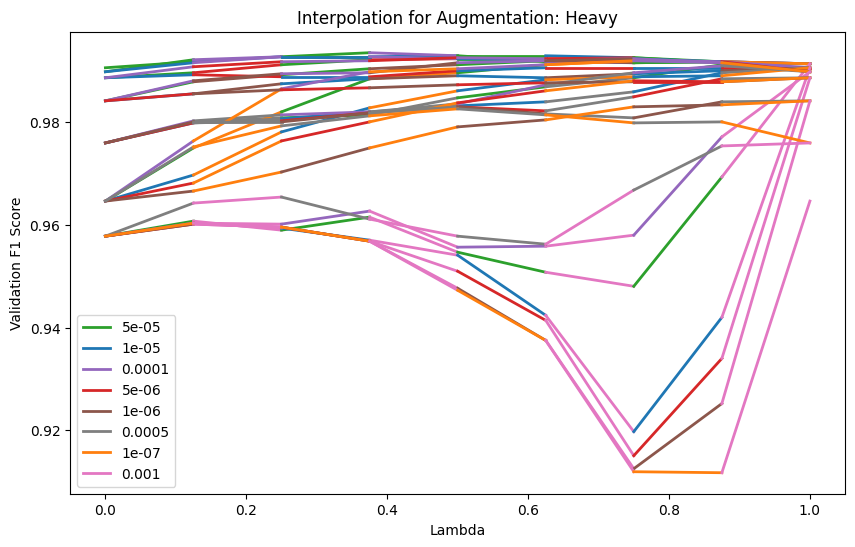

[(23, 29), (23, 35), (23, 17), (23, 41), (23, 11), (23, 47), (23, 5), (29, 35), (29, 17), (29, 41), (29, 11), (29, 47), (29, 5), (35, 17), (35, 41), (35, 11), (35, 47), (35, 5), (17, 41), (17, 11), (17, 47), (17, 5), (41, 11), (41, 47), (41, 5), (11, 47), (11, 5), (47, 5)]


100%|██████████| 40/40 [00:14<00:00,  2.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


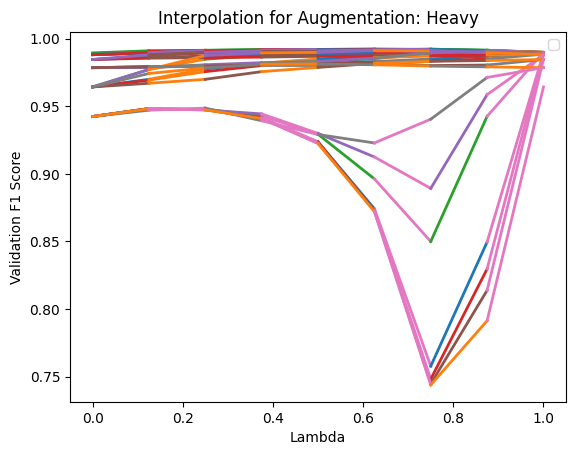

Medium {0: [26, 32, 20, 14, 38, 8, 44, 2], 1: [27, 33, 21, 39, 15, 9, 45, 3]}
{1e-05, 1e-07, 5e-05, 5e-06, 0.0001, 1e-06, 0.001, 0.0005} {1e-05: 'C0', 1e-07: 'C1', 5e-05: 'C2', 5e-06: 'C3', 0.0001: 'C4', 1e-06: 'C5', 0.001: 'C6', 0.0005: 'C7'}
[(26, 32), (26, 20), (26, 14), (26, 38), (26, 8), (26, 44), (26, 2), (32, 20), (32, 14), (32, 38), (32, 8), (32, 44), (32, 2), (20, 14), (20, 38), (20, 8), (20, 44), (20, 2), (14, 38), (14, 8), (14, 44), (14, 2), (38, 8), (38, 44), (38, 2), (8, 44), (8, 2), (44, 2)]


100%|██████████| 40/40 [00:14<00:00,  2.72it/s]


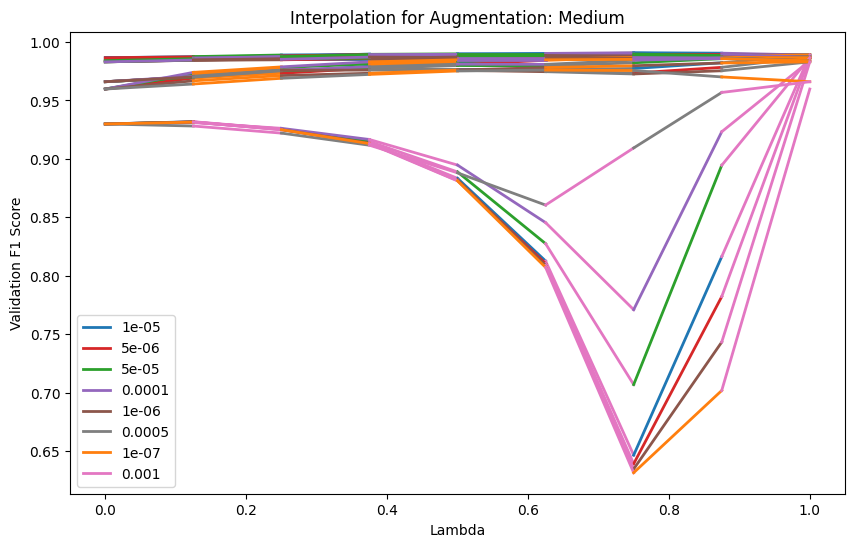

[(27, 33), (27, 21), (27, 39), (27, 15), (27, 9), (27, 45), (27, 3), (33, 21), (33, 39), (33, 15), (33, 9), (33, 45), (33, 3), (21, 39), (21, 15), (21, 9), (21, 45), (21, 3), (39, 15), (39, 9), (39, 45), (39, 3), (15, 9), (15, 45), (15, 3), (9, 45), (9, 3), (45, 3)]


  0%|          | 0/40 [00:00<?, ?it/s]

In [37]:
# import itertools
# import matplotlib.pyplot as plt

# lambda_values = [i / 8 for i in range(9)]

# # Iterate through vary_lr
# for augmentation, seed_lr_dict in vary_lr.items():
#     print(augmentation, seed_lr_dict)
#     plt.figure(figsize=(10, 6))
#     all_lr = set(lr for seed_list in seed_lr_dict.values() for model_id in seed_list for lr in df[df['Model Name'] == model_id]['Learning Rate'])
    
#     # Assign unique color for each LR
#     lr_colors = {lr: f'C{i}' for i, lr in enumerate(all_lr)}
#     print(all_lr, lr_colors)
    
#     # Store LR labels for legend
#     legend_labels = set()
    
#     # Plotting
#     for seed, model_ids in seed_lr_dict.items():
#         # Generate combinations of model_ids
#         combinations = list(itertools.combinations(model_ids, 2))
#         print(combinations)
        
#         for model_id1, model_id2 in combinations:
#             lr1 = df[df['Model Name'] == model_id1]['Learning Rate'].iloc[0]
#             lr2 = df[df['Model Name'] == model_id2]['Learning Rate'].iloc[0]
            
#             # Interpolate and compute performance metrics
#             val_losses = []
#             val_accs = []
#             val_f1s = []
#             val_recalls = []
#             val_kappas = []
#             val_aucs = []
                
#             for l in lambda_values:
#                 if l == 0:
#                     l = 1e-8
#                 if l == 1:
#                     l = 1 - 1e-8
#                 alphal = [l, 1 - l]
#                 final_model = get_model(MODEL, num_classes=NUM_CLASSES)
#                 final_model = souping(final_model, [state_dicts[model_id1], state_dicts[model_id2]], alphal)
#                 final_model = final_model.to(DEVICE)
#                 val_loss, val_acc, val_f1, val_recall, val_kappa, val_auc = val_step(final_model, val_loader, train_loader, loss, DEVICE, CLASSIFICATION)
#                 val_accs.append(val_acc)
            
#             # Plot interpolation curve segment with alternating LR-based colors
#             color_toggle = True
#             for i in range(len(lambda_values) - 1):
#                 color = lr_colors[lr1] if color_toggle else lr_colors[lr2]
#                 label = lr1 if color_toggle else lr2
#                 plt.plot(lambda_values[i:i+2], val_accs[i:i+2], color=color, linestyle='-', linewidth=2, label=label if label not in legend_labels else "")
#                 legend_labels.add(label)
#                 color_toggle = not color_toggle  # Toggle color for the next segment
            
#         # Create legend
#         plt.legend()

#         plt.xlabel('Lambda')
#         plt.ylabel('Validation F1 Score')
#         plt.title(f'Interpolation for Augmentation: {augmentation}')
            
#         # Save the figure
#         plt.savefig(f'./plots/{DATASET}_interpolation_{augmentation}.png')
#         plt.show()


Heavy {1: [29, 23, 35, 17, 11, 41, 47, 5], 0: [28, 34, 22, 10, 16, 40, 46, 4]}
{1e-05, 1e-07, 5e-05, 5e-06, 0.0001, 1e-06, 0.001, 0.0005} {1e-05: 'C0', 1e-07: 'C1', 5e-05: 'C2', 5e-06: 'C3', 0.0001: 'C4', 1e-06: 'C5', 0.001: 'C6', 0.0005: 'C7'}
[1e-05, 5e-05, 5e-06, 0.0001, 0.0005, 1e-06, 1e-07, 0.001]
[(29, 23), (29, 35), (29, 17), (29, 11), (29, 41), (29, 47), (29, 5), (23, 35), (23, 17), (23, 11), (23, 41), (23, 47), (23, 5), (35, 17), (35, 11), (35, 41), (35, 47), (35, 5), (17, 11), (17, 41), (17, 47), (17, 5), (11, 41), (11, 47), (11, 5), (41, 47), (41, 5), (47, 5)]
[(47, 5), (29, 47), (17, 11), (29, 41), (29, 5), (23, 17), (11, 47), (35, 17), (17, 41), (11, 5), (35, 41), (23, 5), (41, 5), (23, 41), (29, 35), (29, 11)]
47 5


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


29 47


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/santoshsanjeev/.conda/envs/nunoodles/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x7ff1225fe160>
Traceback (most recent call last):
  File "/home/santoshsanjeev/.conda/envs/nunoodles/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    close()
  File "/home/santoshsanjeev/.conda/envs/nunoodles/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/santoshsanjeev/.conda/envs/nunoodles/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    self._close()
  File "/home/santoshsanjeev/.conda/envs/nunoodles/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handli

17 11


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


29 41


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


29 5


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


23 17


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


11 47


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


35 17


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


17 41


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


11 5


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


35 41


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


23 5


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


41 5


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


23 41


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


29 35


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


29 11


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


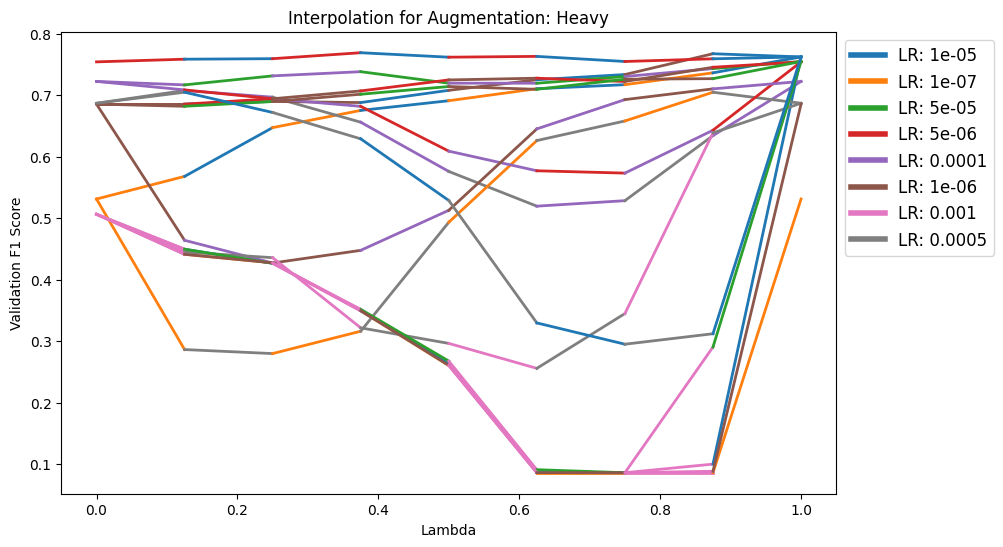

[1e-05, 5e-06, 5e-05, 0.0005, 0.0001, 1e-06, 1e-07, 0.001]
[(28, 34), (28, 22), (28, 10), (28, 16), (28, 40), (28, 46), (28, 4), (34, 22), (34, 10), (34, 16), (34, 40), (34, 46), (34, 4), (22, 10), (22, 16), (22, 40), (22, 46), (22, 4), (10, 16), (10, 40), (10, 46), (10, 4), (16, 40), (16, 46), (16, 4), (40, 46), (40, 4), (46, 4)]
[(22, 46), (16, 4), (34, 16), (28, 40), (22, 10), (10, 4), (28, 22), (16, 40), (28, 4), (34, 10), (34, 40), (22, 40), (34, 22), (28, 16), (16, 46), (28, 10)]
22 46


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


16 4


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


34 16


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


28 40


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


22 10


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


10 4


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


28 22


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


16 40


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


28 4


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


34 10


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


34 40


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


22 40


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


34 22


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


28 16


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


16 46


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


28 10


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


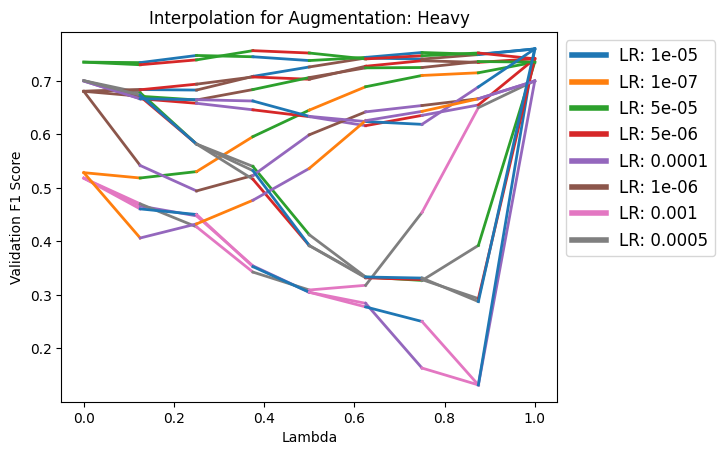

Medium {1: [33, 27, 21, 15, 9, 39, 3, 45], 0: [32, 26, 20, 38, 14, 8, 2, 44]}
{1e-05, 1e-07, 5e-05, 5e-06, 0.0001, 1e-06, 0.001, 0.0005} {1e-05: 'C0', 1e-07: 'C1', 5e-05: 'C2', 5e-06: 'C3', 0.0001: 'C4', 1e-06: 'C5', 0.001: 'C6', 0.0005: 'C7'}
[5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 1e-06, 0.001, 1e-07]
[(33, 27), (33, 21), (33, 15), (33, 9), (33, 39), (33, 3), (33, 45), (27, 21), (27, 15), (27, 9), (27, 39), (27, 3), (27, 45), (21, 15), (21, 9), (21, 39), (21, 3), (21, 45), (15, 9), (15, 39), (15, 3), (15, 45), (9, 39), (9, 3), (9, 45), (39, 3), (39, 45), (3, 45)]
[(27, 9), (21, 3), (27, 45), (15, 39), (21, 9), (9, 45), (21, 15), (15, 45), (9, 39), (15, 3), (15, 9), (39, 45), (27, 39), (33, 9), (33, 45), (21, 39)]
27 9


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


21 3


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


27 45


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


15 39


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


21 9


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


9 45


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


21 15


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


15 45


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


9 39


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


15 3


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


15 9


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


39 45


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


27 39


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


33 9


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


33 45


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


21 39


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


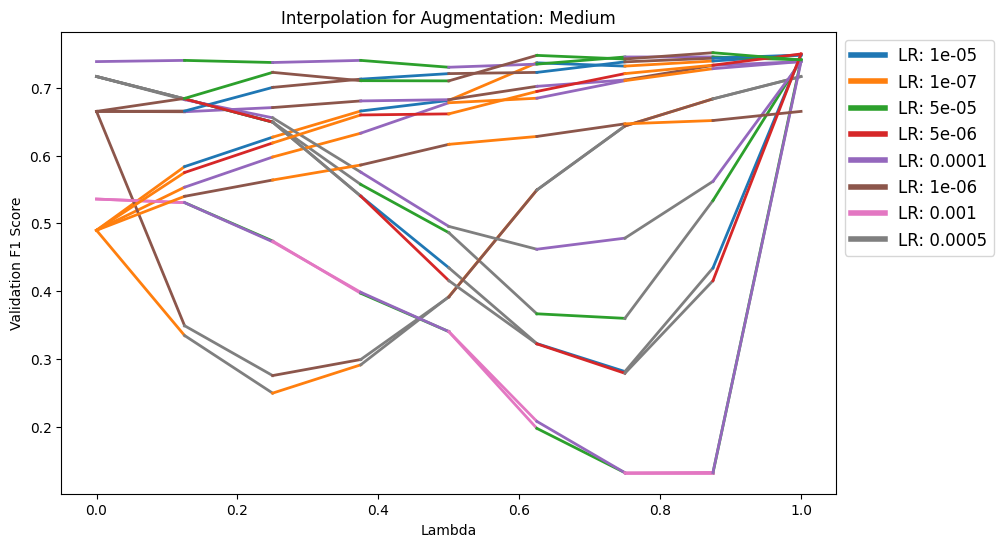

[5e-06, 1e-05, 5e-05, 1e-06, 0.0001, 0.0005, 0.001, 1e-07]
[(32, 26), (32, 20), (32, 38), (32, 14), (32, 8), (32, 2), (32, 44), (26, 20), (26, 38), (26, 14), (26, 8), (26, 2), (26, 44), (20, 38), (20, 14), (20, 8), (20, 2), (20, 44), (38, 14), (38, 8), (38, 2), (38, 44), (14, 8), (14, 2), (14, 44), (8, 2), (8, 44), (2, 44)]
[(32, 20), (14, 2), (26, 38), (26, 8), (26, 20), (32, 2), (14, 44), (20, 14), (32, 8), (38, 8), (38, 14), (38, 2), (32, 14), (20, 44), (8, 2), (20, 38)]
32 20


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


14 2


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


26 38


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


26 8


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


26 20


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


32 2


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


14 44


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


20 14


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


32 8


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


38 8


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


38 14


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


38 2


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


32 14


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


20 44


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


8 2


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


20 38


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


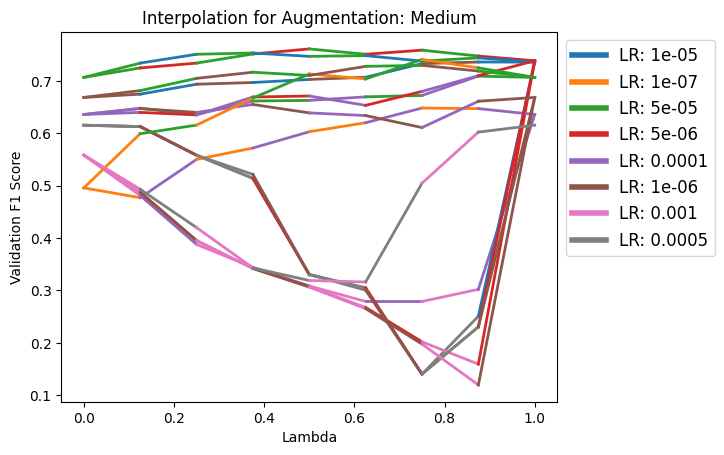

Minimal {1: [31, 19, 25, 13, 37, 7, 43, 1], 0: [24, 18, 30, 36, 12, 42, 6, 0]}
{1e-05, 1e-07, 5e-05, 5e-06, 0.0001, 1e-06, 0.001, 0.0005} {1e-05: 'C0', 1e-07: 'C1', 5e-05: 'C2', 5e-06: 'C3', 0.0001: 'C4', 1e-06: 'C5', 0.001: 'C6', 0.0005: 'C7'}
[5e-06, 5e-05, 1e-05, 0.0001, 1e-06, 0.0005, 1e-07, 0.001]
[(31, 19), (31, 25), (31, 13), (31, 37), (31, 7), (31, 43), (31, 1), (19, 25), (19, 13), (19, 37), (19, 7), (19, 43), (19, 1), (25, 13), (25, 37), (25, 7), (25, 43), (25, 1), (13, 37), (13, 7), (13, 43), (13, 1), (37, 7), (37, 43), (37, 1), (7, 43), (7, 1), (43, 1)]
[(25, 1), (25, 37), (7, 43), (19, 43), (19, 25), (13, 37), (19, 7), (19, 1), (31, 13), (37, 7), (37, 43), (13, 1), (19, 37), (13, 7), (31, 19), (31, 7)]
25 1


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


25 37


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


7 43


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


19 43


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


19 25


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


13 37


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


19 7


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


19 1


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


31 13


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


37 7


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


37 43


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


13 1


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


19 37


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


13 7


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


31 19


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


31 7


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


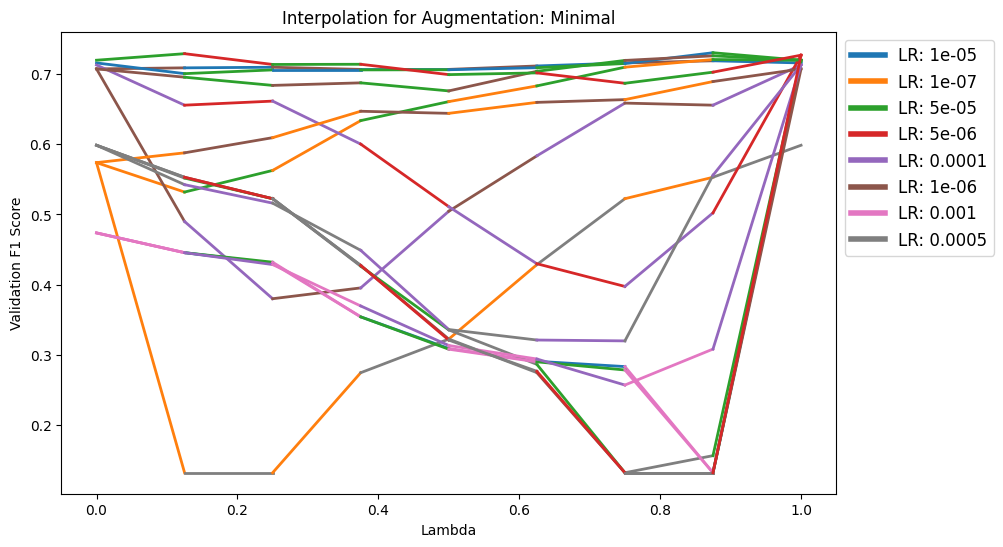

[1e-05, 5e-05, 5e-06, 1e-06, 0.0001, 1e-07, 0.0005, 0.001]
[(24, 18), (24, 30), (24, 36), (24, 12), (24, 42), (24, 6), (24, 0), (18, 30), (18, 36), (18, 12), (18, 42), (18, 6), (18, 0), (30, 36), (30, 12), (30, 42), (30, 6), (30, 0), (36, 12), (36, 42), (36, 6), (36, 0), (12, 42), (12, 6), (12, 0), (42, 6), (42, 0), (6, 0)]
[(36, 0), (30, 0), (12, 0), (30, 6), (24, 30), (24, 36), (6, 0), (24, 42), (24, 18), (42, 6), (30, 12), (24, 0), (24, 6), (30, 36), (30, 42), (36, 12)]
36 0


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


30 0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


12 0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


30 6


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


24 30


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


24 36


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


6 0


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


24 42


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


24 18


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


42 6


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


30 12


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


24 0


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


24 6


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


30 36


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


30 42


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


36 12


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


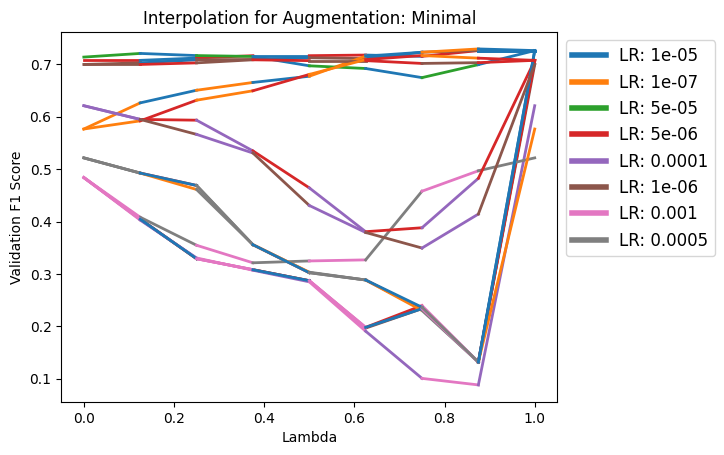

In [10]:
import itertools
import random

lambda_values = [i / 8 for i in range(9)]

# Iterate through vary_lr
for augmentation, seed_lr_dict in vary_lr.items():
    print(augmentation, seed_lr_dict)
    plt.figure(figsize=(10, 6))
    all_lr = set(lr for seed_list in seed_lr_dict.values() for model_id in seed_list for lr in df[df['Model Name'] == model_id]['Learning Rate'])
    
    # Assign unique color for each LR
    lr_colors = {lr: f'C{i}' for i, lr in enumerate(all_lr)}
    print(all_lr, lr_colors)
    # Plotting
    for seed, model_ids in seed_lr_dict.items():
        # Get LR for each model_id
        lrs = [df[df['Model Name'] == model_id]['Learning Rate'].iloc[0] for model_id in model_ids]
        print(lrs)
        # Generate combinations of model_ids
        combinations = list(itertools.combinations(model_ids, 2))
        print(combinations)
        num_combinations = int(0.6 * len(combinations))  # Selecting 60% of combinations
        selected_combinations = random.sample(combinations, num_combinations)
        print(selected_combinations)
        for model_id1, model_id2 in selected_combinations:
            print(model_id1, model_id2)
            lr1 = df[df['Model Name'] == model_id1]['Learning Rate'].iloc[0]
            lr2 = df[df['Model Name'] == model_id2]['Learning Rate'].iloc[0]
            
            # Interpolate and compute performance metrics
            val_losses = []
            val_accs = []
            val_f1s = []
            val_recalls = []
            val_kappas = []
            val_aucs = []
                
            for l in lambda_values:
                if l == 0:
                    l = 1e-8
                if l == 1:
                    l = 1 - 1e-8
                alphal = [l, 1 - l]
                final_model = get_model(MODEL, num_classes=NUM_CLASSES)
                final_model = souping(final_model, [state_dicts[model_id1], state_dicts[model_id2]], alphal)
                final_model = final_model.to(DEVICE)
                val_loss, val_acc, val_f1, val_recall, val_kappa, val_auc = val_step(final_model, val_loader, train_loader, loss, DEVICE, CLASSIFICATION)
                val_f1s.append(val_f1)
            
            # Plot interpolation with alternating LR-based colors
            color_toggle = False
            for i in range(len(lambda_values) - 1):
                color = lr_colors[lr1] if color_toggle else lr_colors[lr2]
                plt.plot(lambda_values[i:i+2], val_f1s[i:i+2], color=color, linestyle='-', linewidth=2)
                color_toggle = not color_toggle  # Toggle color for the next segment
        
        # Add LR-based colors to legend
        legend_handles = []
        for lr, color in lr_colors.items():
            legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label=f'LR: {lr}'))
        plt.legend(handles=legend_handles, loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))
                
        plt.xlabel('Lambda')
        plt.ylabel('Validation F1 Score')
        plt.title(f'Interpolation for Augmentation: {augmentation}')
        
        # Save the figure
        plt.savefig(f'./plots/{DATASET}_interpolation_{augmentation}_{seed}.png', bbox_inches='tight')
        plt.show()


In [20]:
# import itertools

# # Define lambda values
# lambda_values = [i / 8 for i in range(9)]

# # Iterate through vary_lr
# for augmentation, seed_lr_dict in vary_lr.items():
#     for seed, model_ids in seed_lr_dict.items():
#         plt.figure(figsize=(10, 6))
        
#         # Collect all LR values for this augmentation and seed
#         all_lr = set(df[df['Model Name'].isin(model_ids)]['Learning Rate'])
        
#         # Assign unique color for each LR
#         lr_colors = {lr: f'C{i}' for i, lr in enumerate(all_lr)}
        
#         # Iterate through all combinations of model pairs
#         for model_id_pair in itertools.combinations(model_ids, 2):
#             val_f1s = []
#             for l in lambda_values:
#                 if l == 0:
#                     l = 1e-8
#                 if l == 1:
#                     l = 1 - 1e-8
#                 alphal = [l, 1 - l]
#                 final_model = get_model(MODEL, num_classes=NUM_CLASSES)
#                 final_model = souping(final_model, [state_dicts[model_id_pair[0]], state_dicts[model_id_pair[1]]], alphal)
#                 final_model = final_model.to(DEVICE)
#                 val_loss, val_acc, val_f1, val_recall, val_kappa, val_auc = val_step(final_model, val_loader, train_loader, loss, DEVICE, CLASSIFICATION)
#                 val_f1s.append(val_f1)
            
#             # Plot interpolation with LR-based colors
#             start_lr = df[df['Model Name'] == model_id_pair[0]]['Learning Rate'].iloc[0]
#             plt.plot(lambda_values, val_f1s, color=lr_colors[start_lr], linestyle='-', linewidth=2)
        
#         plt.xlabel('Lambda')
#         plt.ylabel('Validation F1 Score')
#         plt.title(f'Interpolation for Augmentation: {augmentation}, Seed: {seed}')
#         plt.grid(True)
        
#         # Save the figure
#         plt.savefig(f'./plots/interpolation_{augmentation}_seed_{seed}.png')
#         plt.show()


In [3]:
import torch 

criterion = torch.nn.MSELoss()

t1 = torch.nn.Parameter(torch.ones(5))
t2 = torch.nn.Parameter(torch.ones(5))
t3 = torch.nn.Parameter(torch.ones(5), requires_grad=False)
gt = torch.zeros((5,))

out1 = t2*t1
out2 = out1 *t3

loss = criterion(out2, gt)

print(loss.item())

loss.backward()


1.0


In [10]:
out2

tensor([1., 1., 1., 1., 1.], grad_fn=<MulBackward0>)

In [8]:
vary_aug = {}
for ind, row in df.iterrows():
    row['Learning Rate'] = str(row['Learning Rate'])
    row['Augmentation'] = str(row['Augmentation'])
    row['Seed'] = int(row['SEED'])
    if row['Learning Rate'] in vary_aug.keys():
        if row['Seed'] in vary_aug[row['Learning Rate']].keys():
            vary_aug[row['Learning Rate']][row['Seed']].append(int(row['Model Name']))
        else:
            vary_aug[row['Learning Rate']][row['Seed']] = [int(row['Model Name'])]
    else:
        vary_aug[row['Learning Rate']] = {}
        vary_aug[row['Learning Rate']][row['Seed']] = [int(row['Model Name'])]

print(vary_aug)


{'1e-05': {1: [29, 27, 25], 0: [28, 26, 24]}, '5e-05': {1: [23, 21, 19], 0: [22, 18, 20]}, '5e-06': {1: [35, 33, 31], 0: [34, 32, 30]}, '0.0001': {1: [15, 17, 13], 0: [16, 14, 12]}, '0.0005': {1: [9, 11, 7], 0: [10, 8, 6]}, '1e-06': {1: [37, 41, 39], 0: [36, 40, 38]}, '1e-07': {0: [42, 46, 44], 1: [43, 47, 45]}, '0.001': {0: [2, 4, 0], 1: [3, 5, 1]}}


[(29, 27), (29, 25), (27, 25)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


red
green
red
green
red
green
red
green
[(28, 26), (28, 24), (26, 24)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
green
red
green
red
green
red
green


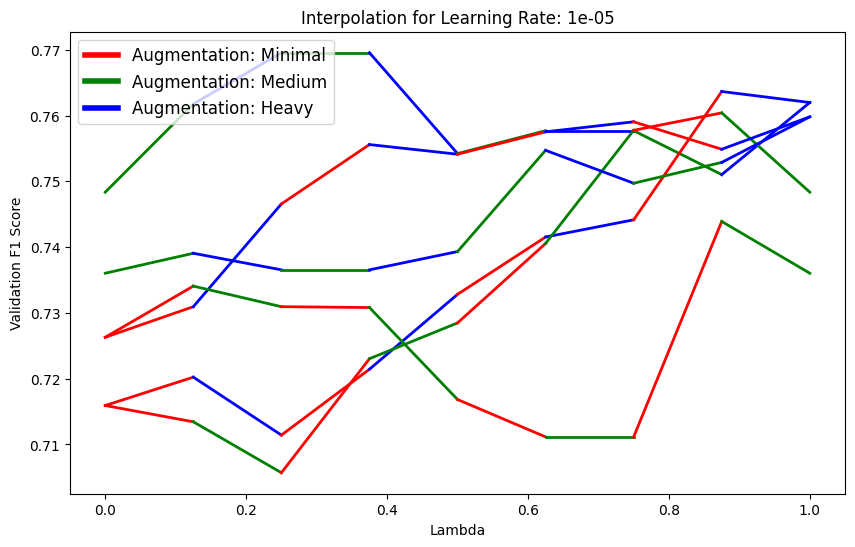

[(23, 21), (23, 19), (21, 19)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


red
green
red
green
red
green
red
green
[(22, 18), (22, 20), (18, 20)]
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


red
blue
red
blue
red
blue
red
blue
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


green
blue
green
blue
green
blue
green
blue
Minimal Medium


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


green
red
green
red
green
red
green
red


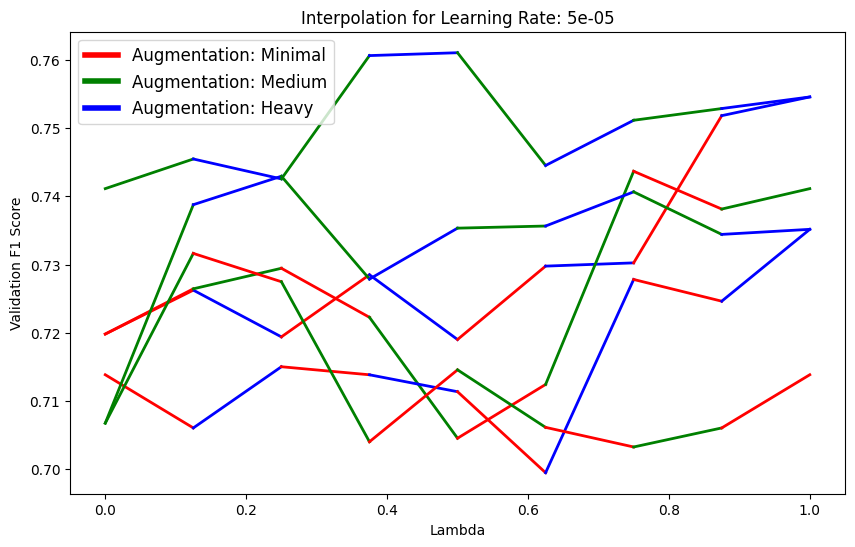

[(35, 33), (35, 31), (33, 31)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
green
red
green
red
green
red
green
[(34, 32), (34, 30), (32, 30)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
green
red
green
red
green
red
green


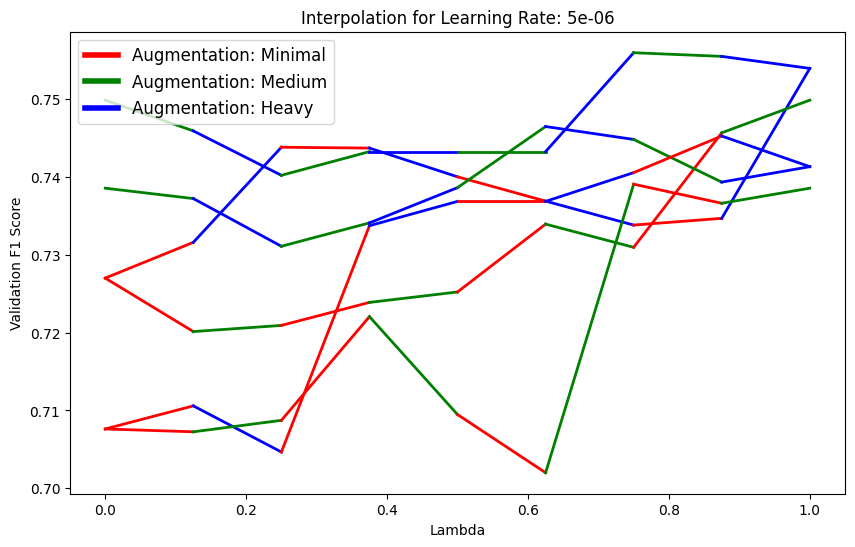

[(15, 17), (15, 13), (17, 13)]
Medium Heavy


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


blue
green
blue
green
blue
green
blue
green
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


red
green
red
green
red
green
red
green
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


red
blue
red
blue
red
blue
red
blue
[(16, 14), (16, 12), (14, 12)]
Heavy Medium


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


red
green
red
green
red
green
red
green


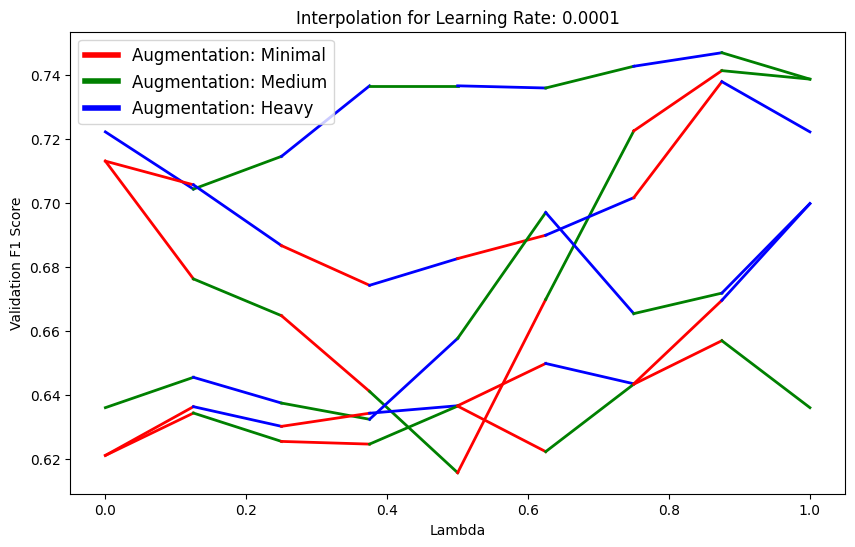

[(9, 11), (9, 7), (11, 7)]
Medium Heavy


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


blue
green
blue
green
blue
green
blue
green
Medium Minimal


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


red
green
red
green
red
green
red
green
Heavy Minimal


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


red
blue
red
blue
red
blue
red
blue
[(10, 8), (10, 6), (8, 6)]
Heavy Medium


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


green
blue
green
blue
green
blue
green
blue
Heavy Minimal


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


red
blue
red
blue
red
blue
red
blue
Medium Minimal


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


red
green
red
green
red
green
red
green


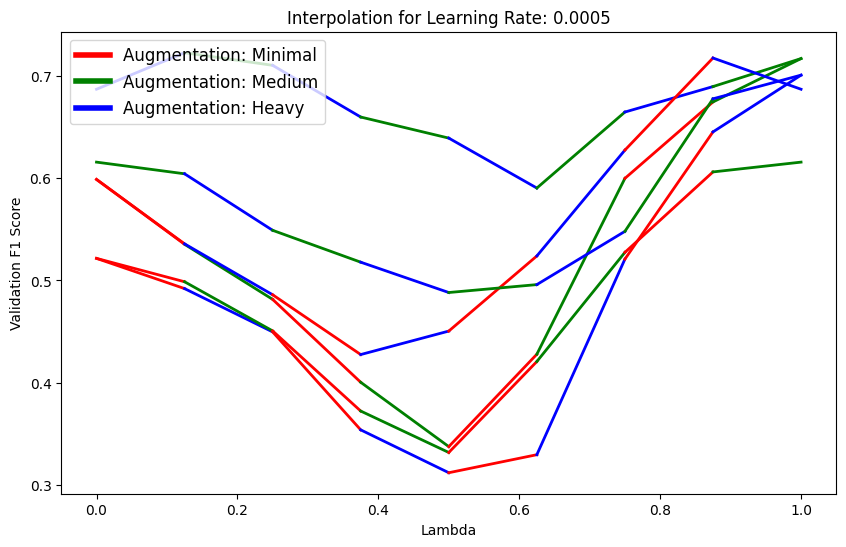

[(37, 41), (37, 39), (41, 39)]
Minimal Heavy


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


blue
red
blue
red
blue
red
blue
red
Minimal Medium


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


green
red
green
red
green
red
green
red
Heavy Medium


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


green
blue
green
blue
green
blue
green
blue
[(36, 40), (36, 38), (40, 38)]
Minimal Heavy


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


blue
red
blue
red
blue
red
blue
red
Minimal Medium


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


green
red
green
red
green
red
green
red
Heavy Medium


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


green
blue
green
blue
green
blue
green
blue


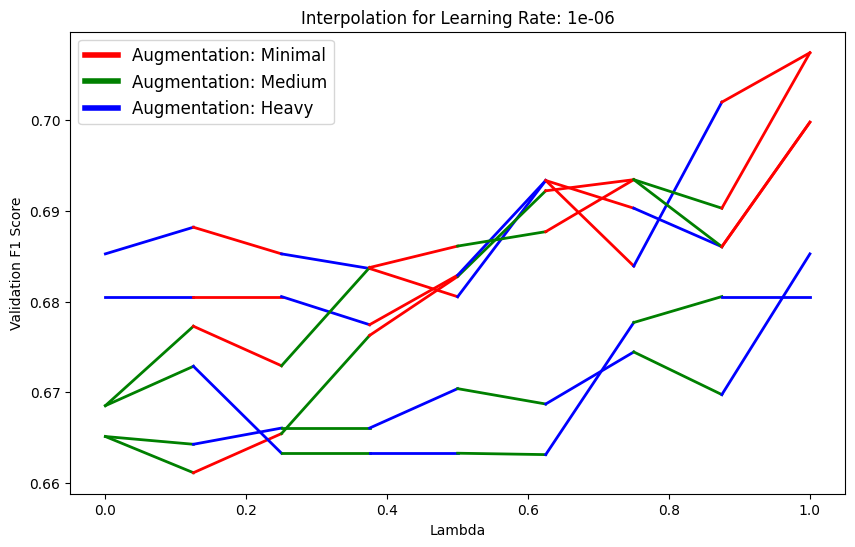

[(42, 46), (42, 44), (46, 44)]
Minimal Heavy


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


blue
red
blue
red
blue
red
blue
red
Minimal Medium


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


green
red
green
red
green
red
green
red
Heavy Medium


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


green
blue
green
blue
green
blue
green
blue
[(43, 47), (43, 45), (47, 45)]
Minimal Heavy


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


blue
red
blue
red
blue
red
blue
red
Minimal Medium


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


green
red
green
red
green
red
green
red
Heavy Medium


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


green
blue
green
blue
green
blue
green
blue


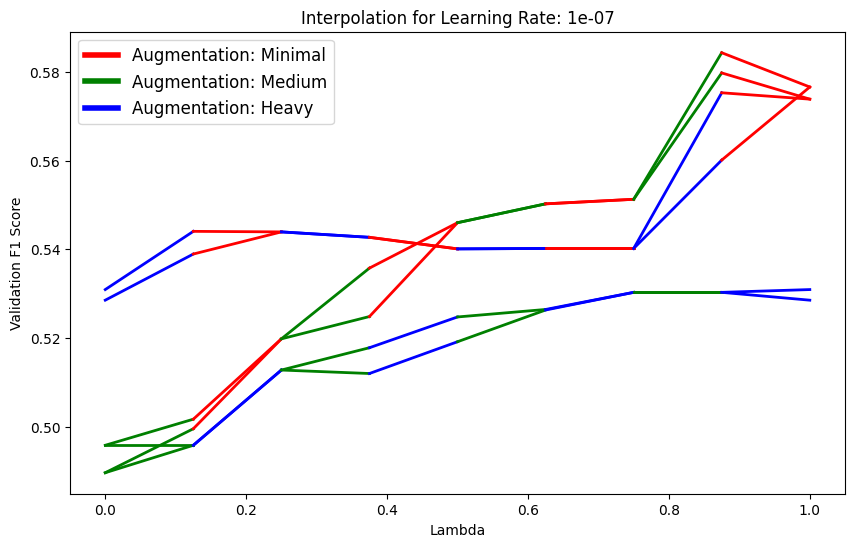

[(2, 4), (2, 0), (4, 0)]
Medium Heavy


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


blue
green
blue
green
blue
green
blue
green
Medium Minimal


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


red
green
red
green
red
green
red
green
Heavy Minimal


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


red
blue
red
blue
red
blue
red
blue
[(3, 5), (3, 1), (5, 1)]
Medium Heavy


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


blue
green
blue
green
blue
green
blue
green
Medium Minimal


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


red
green
red
green
red
green
red
green
Heavy Minimal


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


red
blue
red
blue
red
blue
red
blue


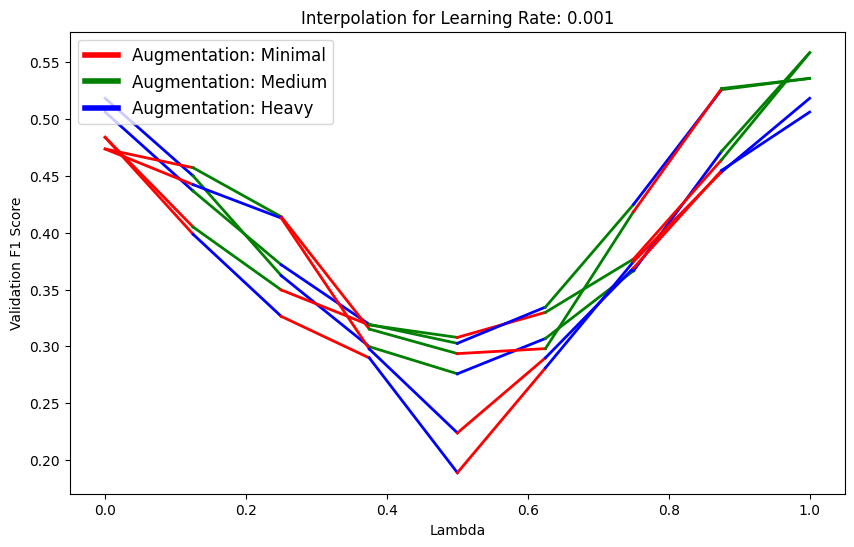

In [13]:
import random
import itertools
lambda_values = [i / 8 for i in range(9)]

# Define colors for each augmentation
augmentation_colors = {'Minimal': 'red', 'Medium': 'green', 'Heavy': 'blue'}

# Iterate through vary_aug
for lr, seed_aug_dict in vary_aug.items():
    plt.figure(figsize=(10, 6))
    
    # Plotting
    for seed, aug_model_ids in seed_aug_dict.items():
        
        selected_combinations = list(itertools.combinations(aug_model_ids, 2))
        print(selected_combinations)
        for model_id1, model_id2 in selected_combinations:
            aug1 = df[df['Model Name'] == model_id1]['Augmentation'].iloc[0]
            aug2 = df[df['Model Name'] == model_id2]['Augmentation'].iloc[0]
            print(aug1, aug2)
            aug_colors = [augmentation_colors[aug1], augmentation_colors[aug2]]
            # Interpolate and compute performance metrics
            val_f1s = []
            for l in lambda_values:
                if l == 0:
                    l = 1e-8
                if l == 1:
                    l = 1 - 1e-8
                alphal = [l, 1 - l]
                final_model = get_model(MODEL, num_classes=NUM_CLASSES)
                final_model = souping(final_model, [state_dicts[model_id1], state_dicts[model_id2]], alphal)
                final_model = final_model.to(DEVICE)
                val_loss, val_acc, val_f1, val_recall, val_kappa, val_auc = val_step(final_model, val_loader, train_loader, loss, DEVICE, CLASSIFICATION)
                val_f1s.append(val_f1)
            
            # Plot interpolation curve segment with alternating augmentation-based colors
            color_toggle = False
            for i in range(len(lambda_values) - 1):
                color = aug_colors[0] if color_toggle else aug_colors[1]
                plt.plot(lambda_values[i:i+2], val_f1s[i:i+2], color=color, linestyle='-', linewidth=2)
                color_toggle = not color_toggle  # Toggle color for the next segment
        
    # Add augmentation-based colors to legend
    legend_handles = []
    for aug, color in augmentation_colors.items():
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label=f'Augmentation: {aug}'))
    plt.legend(handles=legend_handles, loc='upper left', fontsize='large')
    
    plt.xlabel('Lambda')
    plt.ylabel('Validation F1 Score')
    plt.title(f'Interpolation for Learning Rate: {lr}')
    
    # Save the figure
    plt.savefig(f'./plots/linear_connectivity/test/{DATASET}_interpolation_aug_{lr}.png', bbox_inches='tight')
    plt.show()
